# Attention Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

/u3/z3tu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [4]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-attention-lite-fix-params-and-seed',))]

# old: mpcnn-attention-lite-fix-params-and-seed

In [5]:
len(experiment_rows)

90

In [6]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if 'attention' in args:
        if args['attention'] == 'basic':
            arch = 'Attention'
        elif args['attention'] == 'idf':
            arch = 'idf-Attention'
    else:
        arch = 'MP-CNN Lite'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [7]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [8]:
trecqa['arch'].unique()

array(['MP-CNN Lite', 'Attention', 'idf-Attention'], dtype=object)

In [9]:
archs = ['MP-CNN Lite', 'Attention', 'idf-Attention']
def compare_change_to_baseline(df, metric):
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN Lite')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with single baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with single baseline: {np.mean(diffs):.4f}')

## TrecQA

In [10]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [11]:
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN Lite: (0.7487, 0.7781)
Attention: (0.7641, 0.7867)
idf-Attention: (0.7716, 0.7869)


In [12]:
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN Lite: (0.8165, 0.8475)
Attention: (0.8261, 0.8494)
idf-Attention: (0.8242, 0.8545)


In [13]:
trec_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Attention,0.77540,497878.4
MP-CNN Lite,0.76339,497878.4
idf-Attention,0.77929,497878.4


In [14]:
trec_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Attention,0.83778,497878.4
MP-CNN Lite,0.83201,497878.4
idf-Attention,0.83932,497878.4


In [15]:
compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: MP-CNN Lite
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: Attention
Median of MAP change compared with single baseline: 0.0169
Mean of MAP change compared with single baseline: 0.0120
Architecture: idf-Attention
Median of MAP change compared with single baseline: 0.0141
Mean of MAP change compared with single baseline: 0.0159


In [16]:
compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: MP-CNN Lite
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: Attention
Median of MRR change compared with single baseline: 0.0032
Mean of MRR change compared with single baseline: 0.0058
Architecture: idf-Attention
Median of MRR change compared with single baseline: 0.0024
Mean of MRR change compared with single baseline: 0.0073


## WikiQA

In [17]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [18]:
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN Lite: (0.6730, 0.6879)
Attention: (0.6809, 0.6924)
idf-Attention: (0.6833, 0.6977)


In [19]:
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN Lite: (0.6851, 0.7010)
Attention: (0.6963, 0.7070)
idf-Attention: (0.6968, 0.7124)


In [20]:
wikiqa_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Attention,0.68664,497878.4
MP-CNN Lite,0.68044,497878.4
idf-Attention,0.69049,497878.4


In [21]:
wikiqa_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Attention,0.70164,497878.4
MP-CNN Lite,0.69303,497878.4
idf-Attention,0.70461,497878.4


In [22]:
compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: MP-CNN Lite
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: Attention
Median of MAP change compared with single baseline: 0.0048
Mean of MAP change compared with single baseline: 0.0062
Architecture: idf-Attention
Median of MAP change compared with single baseline: 0.0109
Mean of MAP change compared with single baseline: 0.0100


In [23]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: MP-CNN Lite
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: Attention
Median of MRR change compared with single baseline: 0.0071
Mean of MRR change compared with single baseline: 0.0086
Architecture: idf-Attention
Median of MRR change compared with single baseline: 0.0135
Mean of MRR change compared with single baseline: 0.0116


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,  0.73]),
 <a list of 10 Text yticklabel objects>)

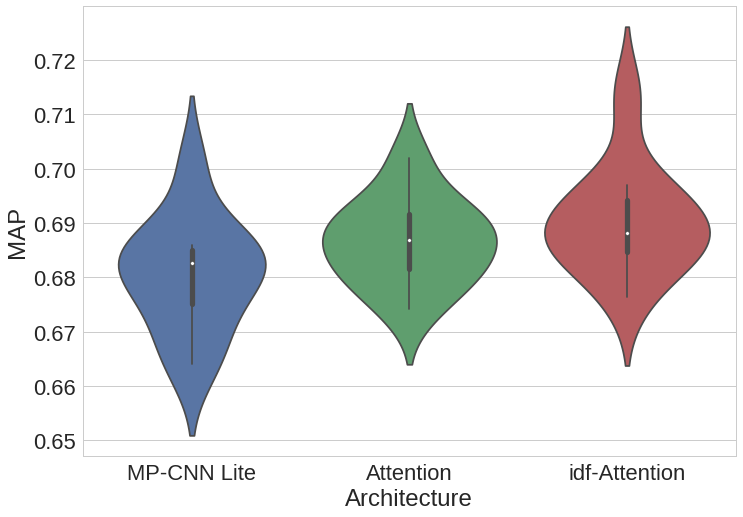

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.6, 0.75)

## SICK

In [25]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [26]:
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN Lite: (0.8598, 0.8649)
Attention: (0.8617, 0.8663)
idf-Attention: (0.8622, 0.8670)


In [27]:
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN Lite: (0.7953, 0.8015)
Attention: (0.7981, 0.8037)
idf-Attention: (0.7999, 0.8047)


In [28]:
sick_pearson_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Attention,0.863985,497878.4
MP-CNN Lite,0.862349,497878.4
idf-Attention,0.864560,497878.4


In [29]:
sick_spearman_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Attention,0.800891,497878.4
MP-CNN Lite,0.798418,497878.4
idf-Attention,0.802307,497878.4


In [30]:
compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: MP-CNN Lite
Median of pearson change compared with single baseline: 0.0000
Mean of pearson change compared with single baseline: 0.0000
Architecture: Attention
Median of pearson change compared with single baseline: 0.0013
Mean of pearson change compared with single baseline: 0.0016
Architecture: idf-Attention
Median of pearson change compared with single baseline: 0.0022
Mean of pearson change compared with single baseline: 0.0022


In [31]:
compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: MP-CNN Lite
Median of spearman change compared with single baseline: 0.0000
Mean of spearman change compared with single baseline: 0.0000
Architecture: Attention
Median of spearman change compared with single baseline: 0.0023
Mean of spearman change compared with single baseline: 0.0025
Architecture: idf-Attention
Median of spearman change compared with single baseline: 0.0032
Mean of spearman change compared with single baseline: 0.0039


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.8525,  0.855 ,  0.8575,  0.86  ,  0.8625,  0.865 ,  0.8675,
         0.87  ,  0.8725,  0.875 ,  0.8775]),
 <a list of 11 Text yticklabel objects>)

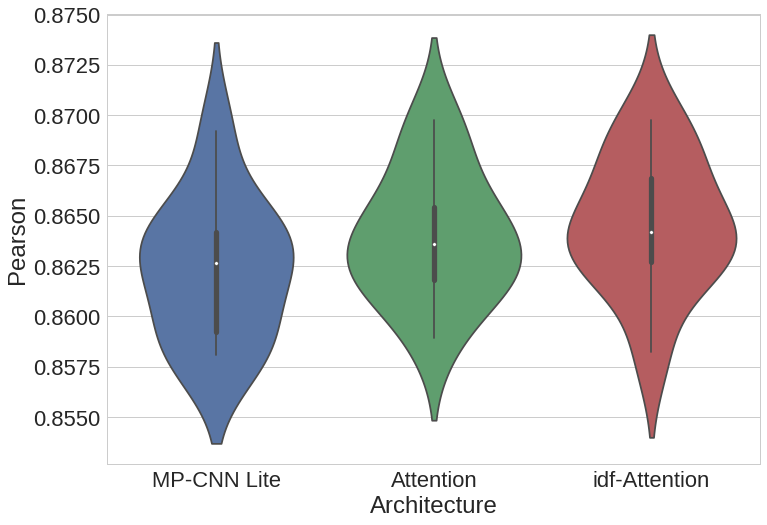

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('Pearson', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.86, 0.88)

/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


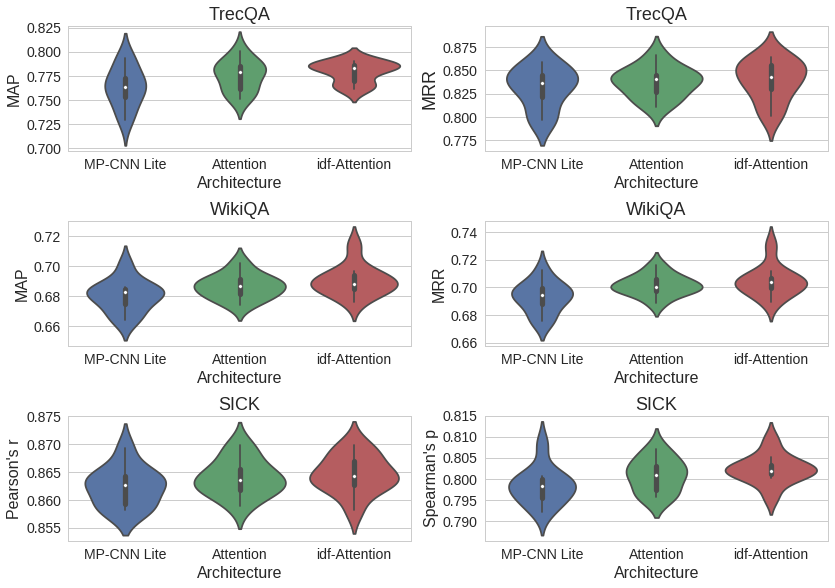

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(322)
sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=18)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(323)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(324)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(325)
sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Pearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)

ax = plt.subplot(326)
sns.violinplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)
plt.tight_layout()
plt.savefig('attention_violin.pdf')